Лабораторная №5

Подключаем библиотеки

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

Загружаем исходное изображение

In [4]:
image = cv.imread('periodic_noise.jpg')
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 

Пишем функцию сравнения двух изображений

In [5]:
def image_diff(image1, title1, image2, title2):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(image1, cmap='gray')
    plt.title(title1)

    plt.subplot(1,2,2)
    plt.imshow(image2, cmap='gray')
    plt.title(title2)

    plt.show()

Реализация высокочастотного фильтра на основе ядра Гаусса.

In [6]:
def gaussian_filter(image):
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    rows, cols = image.shape
    x, y = np.ogrid[:rows, :cols]
    center_x, center_y = rows // 2, cols // 2
    
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    sigma = 40
    gaussian_lowpass = np.exp(-(distance**2) / (2 * (sigma**2)))
    gaussian_highpass = 1 - gaussian_lowpass
    
    mask = np.zeros((rows, cols, 2), np.float32)
    mask[:,:,0] = gaussian_highpass
    mask[:,:,1] = gaussian_highpass
    
    dft_shift_filtered = dft_shift * mask
    f_ishift = np.fft.ifftshift(dft_shift_filtered)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

    img_back = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    
    return img_back, gaussian_highpass

Тестируем написанную функцию.

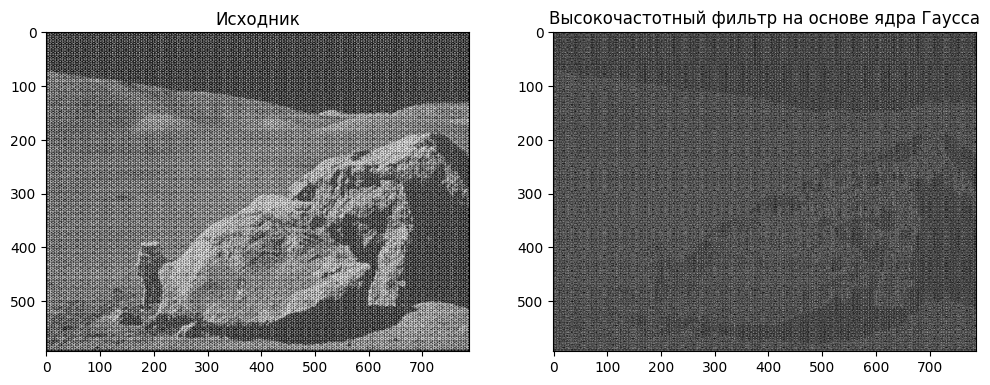

In [7]:
highpass_result, gaussian_mask = gaussian_filter(image_gray)
image_diff(image_gray, 'Исходник', highpass_result, 'Высокочастотный фильтр на основе ядра Гаусса')

Реализация удаления периодического шума

In [8]:
def remove_periodic_noise(image):
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    magnitude = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    threshold = np.percentile(magnitude, 96)
    noise_mask = magnitude > threshold
    
    rows, cols = image.shape
    center_y, center_x = rows // 2, cols // 2
    center_radius = min(rows, cols) // 10
    
    filter_mask = np.ones((rows, cols, 2), np.float32)
    
    for y in range(rows):
        for x in range(cols):
            if noise_mask[y, x]:
                dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                if dist > center_radius:
                    filter_mask[y, x] = 0
                    filter_mask[rows-1-y, cols-1-x] = 0
    

    fshift = dft_shift * filter_mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

    denoised_image = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    
    return denoised_image, magnitude

Тестирование написанной функции.

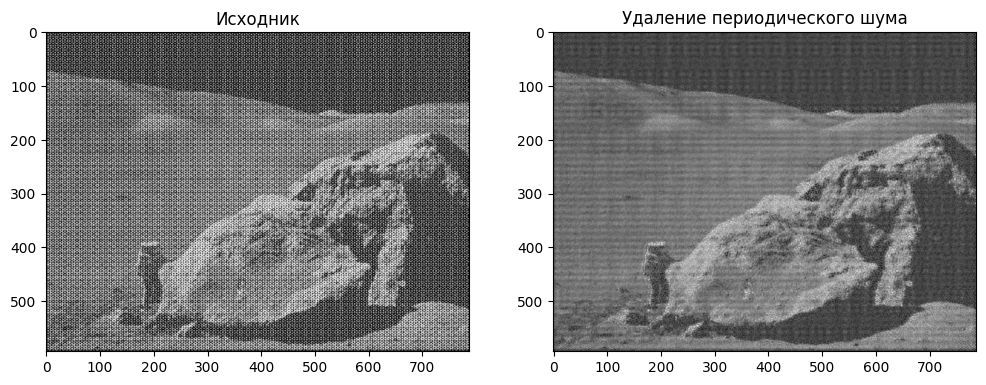

In [9]:
denoised_image, magnitude = remove_periodic_noise(image_gray)
image_diff(image_gray, 'Исходник', denoised_image, 'Удаление периодического шума')